# Time Series Forecasting of Cryptocurrencies

# imports

In [99]:
!pip install pmdarima --quiet

In [100]:
# analysis
import pandas as pd
import numpy as np
import glob

# # define random seed of numpy
seed_value = 42
np.random.seed(seed_value)

# plot
import matplotlib.pyplot as plt
import seaborn as sns
# import plotly.express as plx
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [16, 4]

# # progress
import traceback
from tqdm import tqdm
tqdm.pandas(desc="Processing Rows")

# # output
import warnings
warnings.filterwarnings('ignore')

# # forecast
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# # expand display output
pd.set_option('display.max_columns', None)

# ENGINEERING

Lendo todos os arquivos da pasta ``raw_data``, e armazenando um arquivo concatenado identificando cada dataset pelo ticker do criptoativo

In [101]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [102]:
# Obtendo a lista de nomes de arquivo no diretório ../external_variables/
#file_names = glob.glob('../raw_data/*')
file_names = glob.glob("../content/drive/MyDrive/01 - Projetos/crypto_forecast/raw_data/*")

# Dicionário para armazenar os DataFrames tratados
data_frames = {}

for file_name in file_names:
    # Obtendo o nome do arquivo sem a extensão
    name = file_name.split('/')[-1].split('.')[0]

    # Lendo o arquivo CSV e aplicando os tratamentos
    df = pd.read_csv(file_name, sep=';')
    cols_to_keep = ['close', 'volume', 'marketCap', 'timestamp']
    cols_to_rename = {'timestamp': 'date', 'marketCap': 'market_cap'}
    df = df[cols_to_keep].rename(columns=cols_to_rename)
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

    # Extrair o ticker da parte inicial do nome da chave
    ticker = name.split('_')[0]

    # Adicionar a coluna 'ticker' ao DataFrame com o valor do ticker
    df['ticker'] = ticker

    # Armazenando o DataFrame tratado no dicionário
    data_frames[name] = df

# Acesse cada DataFrame usando seus nomes de arquivo como chaves, por exemplo:
data_frames.keys()

dict_keys(['ETH_1M_graph_coinmarketcap', 'USDT_1M_graph_coinmarketcap', 'BNB_1M_graph_coinmarketcap', 'SOL_1M_graph_coinmarketcap', 'XRP_1M_graph_coinmarketcap', 'USDC_1M_graph_coinmarketcap', 'ADA_1M_graph_coinmarketcap', 'AVAX_1M_graph_coinmarketcap', 'DOGE_1M_graph_coinmarketcap', 'TRX_1M_graph_coinmarketcap', 'DOT_1M_graph_coinmarketcap', 'LINK_1M_graph_coinmarketcap', 'TON_1M_graph_coinmarketcap', 'MATIC_1M_graph_coinmarketcap', 'SHIB_1M_graph_coinmarketcap', 'ICP_1M_graph_coinmarketcap', 'DAI_1M_graph_coinmarketcap', 'LTC_1M_graph_coinmarketcap', 'BCH_1M_graph_coinmarketcap', 'XRP_All_graph_coinmarketcap', 'SOL_All_graph_coinmarketcap', 'BNB_All_graph_coinmarketcap', 'ETH_All_graph_coinmarketcap', 'USDT_All_graph_coinmarketcap', 'BCH_All_graph_coinmarketcap', 'AVAX_All_graph_coinmarketcap', 'USDC_All_graph_coinmarketcap', 'ADA_All_graph_coinmarketcap', 'DOGE_All_graph_coinmarketcap', 'TRX_All_graph_coinmarketcap', 'DOT_All_graph_coinmarketcap', 'TON_All_graph_coinmarketcap', 'MAT

In [103]:
data_frames['BTC_All_graph_coinmarketcap']

,close,volume,market_cap,ticker
date,,,,
2013-04-01 00:00:00+00:00,278.528200,0.000000e+00,3.118457e+09,BTC
2013-05-01 00:00:00+00:00,276.292200,0.000000e+00,2.901242e+09,BTC
2013-06-01 00:00:00+00:00,215.594137,0.000000e+00,2.349464e+09,BTC
2013-07-01 00:00:00+00:00,241.503268,0.000000e+00,2.719703e+09,BTC
2013-08-01 00:00:00+00:00,322.417250,0.000000e+00,3.584583e+09,BTC
...,...,...,...,...
2023-08-01 00:00:00+00:00,128500.820776,2.068772e+12,2.386531e+12,BTC
2023-09-01 00:00:00+00:00,135716.038785,1.673128e+12,2.605974e+12,BTC
2023-10-01 00:00:00+00:00,174590.403638,2.397612e+12,3.407242e+12,BTC


In [104]:
# concatenando
df = pd.DataFrame()

# Concatenar todos os DataFrames no dicionário
for key, value in data_frames.items():
    df = pd.concat([df, value])

# dropando possiveis duplicidades do df 1M
df = df.drop_duplicates()
df

,close,volume,market_cap,ticker
date,,,,
2023-12-18 00:00:00+00:00,10858.874499,5.120793e+10,1.316496e+12,ETH
2023-12-19 00:00:00+00:00,10602.319443,5.200637e+10,1.281978e+12,ETH
2023-12-20 00:00:00+00:00,10824.816911,6.159135e+10,1.270347e+12,ETH
2023-12-21 00:00:00+00:00,10936.357467,6.202413e+10,1.323236e+12,ETH
2023-12-22 00:00:00+00:00,11304.584768,7.880301e+10,1.365436e+12,ETH
...,...,...,...,...
2024-01-12 00:00:00+00:00,208017.841592,2.110822e+11,4.090816e+12,BTC
2024-01-13 00:00:00+00:00,207991.197062,1.000056e+11,4.075719e+12,BTC
2024-01-14 00:00:00+00:00,202878.800096,8.506304e+10,3.976857e+12,BTC


In [105]:
# SAVE SILVER
#silver_path = glob.glob('../silver/')
silver_save_path = "../content/drive/MyDrive/01 - Projetos/crypto_forecast/silver/"
filename = "df_silver.parquet"
silver_save_path = silver_save_path + filename

df.to_parquet(silver_save_path)

In [106]:
# format date
df_month = df.reset_index().copy()
df_month['month'] = df_month['date'].dt.to_period('M').dt.to_timestamp()

df_month

,date,close,volume,market_cap,ticker,month
0,2023-12-18 00:00:00+00:00,10858.874499,5.120793e+10,1.316496e+12,ETH,2023-12-01
1,2023-12-19 00:00:00+00:00,10602.319443,5.200637e+10,1.281978e+12,ETH,2023-12-01
2,2023-12-20 00:00:00+00:00,10824.816911,6.159135e+10,1.270347e+12,ETH,2023-12-01
3,2023-12-21 00:00:00+00:00,10936.357467,6.202413e+10,1.323236e+12,ETH,2023-12-01
4,2023-12-22 00:00:00+00:00,11304.584768,7.880301e+10,1.365436e+12,ETH,2023-12-01
...,...,...,...,...,...,...
3170,2024-01-12 00:00:00+00:00,208017.841592,2.110822e+11,4.090816e+12,BTC,2024-01-01
3171,2024-01-13 00:00:00+00:00,207991.197062,1.000056e+11,4.075719e+12,BTC,2024-01-01
3172,2024-01-14 00:00:00+00:00,202878.800096,8.506304e+10,3.976857e+12,BTC,2024-01-01
3173,2024-01-15 00:00:00+00:00,206769.708598,1.083422e+11,4.044428e+12,BTC,2024-01-01


In [107]:
df_month[df_month["ticker"] == "BCH"].sort_values(by="month").tail(20)

,date,close,volume,market_cap,ticker,month
550,2023-12-28 00:00:00+00:00,1273.633691,3.362145e+09,2.483585e+10,BCH,2023-12-01
551,2023-12-29 00:00:00+00:00,1235.022763,2.227997e+09,2.420179e+10,BCH,2023-12-01
552,2023-12-30 00:00:00+00:00,1315.533576,3.204145e+09,2.578493e+10,BCH,2023-12-01
553,2023-12-31 00:00:00+00:00,1258.064593,1.529101e+09,2.465955e+10,BCH,2023-12-01
568,2024-01-15 00:00:00+00:00,1217.987464,1.104840e+09,2.384249e+10,BCH,2024-01-01
555,2024-01-02 00:00:00+00:00,1265.236884,1.459353e+09,2.445037e+10,BCH,2024-01-01
556,2024-01-03 00:00:00+00:00,1151.178036,2.046023e+09,2.258311e+10,BCH,2024-01-01
557,2024-01-04 00:00:00+00:00,1173.234270,1.091350e+09,2.311090e+10,BCH,2024-01-01
558,2024-01-05 00:00:00+00:00,1167.990477,1.241646e+09,2.300260e+10,BCH,2024-01-01
559,2024-01-06 00:00:00+00:00,1150.804028,1.036533e+09,2.256573e+10,BCH,2024-01-01


In [108]:
df_month_mean = df_month.groupby(["month",  "ticker"]).agg(
    close_mean = ("close", "mean"),
    volume_mean = ("volume", "mean"),
    market_cap_mean = ("market_cap", "mean")
).reset_index()

In [109]:
df_month_mean[df_month_mean["month"] == "2024-01-01"] #.sort_values(by="month").tail(20)

,month,ticker,close_mean,volume_mean,market_cap_mean
1477,2024-01-01,ADA,2.686210,2.996194e+09,9.494998e+10
1478,2024-01-01,AVAX,178.769173,6.733050e+09,6.546532e+10
1479,2024-01-01,BCH,1219.288683,1.595661e+09,2.388618e+10
1480,2024-01-01,BNB,1508.975261,5.807533e+09,2.286786e+11
1481,2024-01-01,BTC,215901.032926,1.552184e+11,4.226342e+12
1482,2024-01-01,DAI,4.879981,2.183443e+09,2.607515e+10
1483,2024-01-01,DOGE,0.403609,2.657567e+09,5.748838e+10
1484,2024-01-01,DOT,37.008969,2.657375e+09,4.723732e+10
1485,2024-01-01,ETH,11739.052027,6.710541e+10,1.409465e+12
1486,2024-01-01,ICP,63.004284,2.371985e+09,2.863966e+10


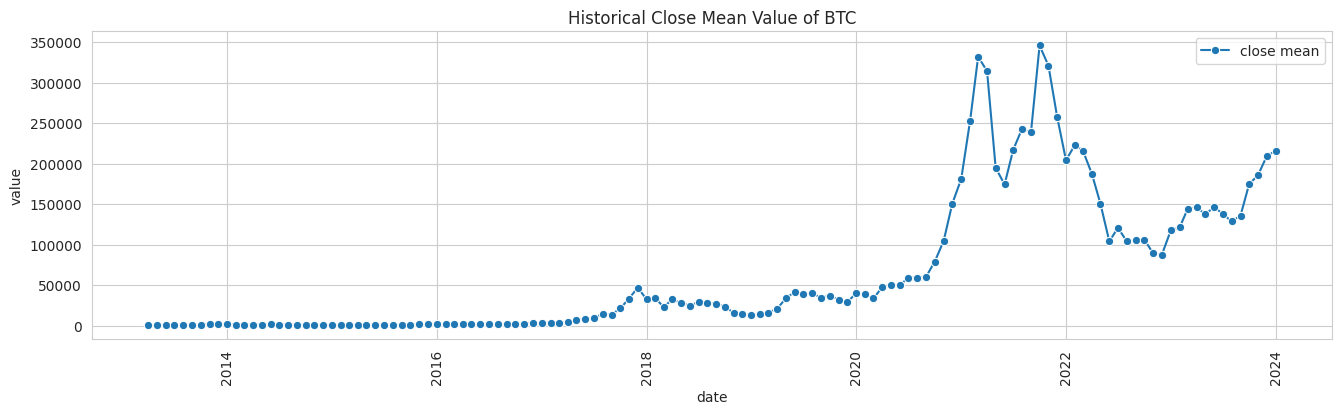

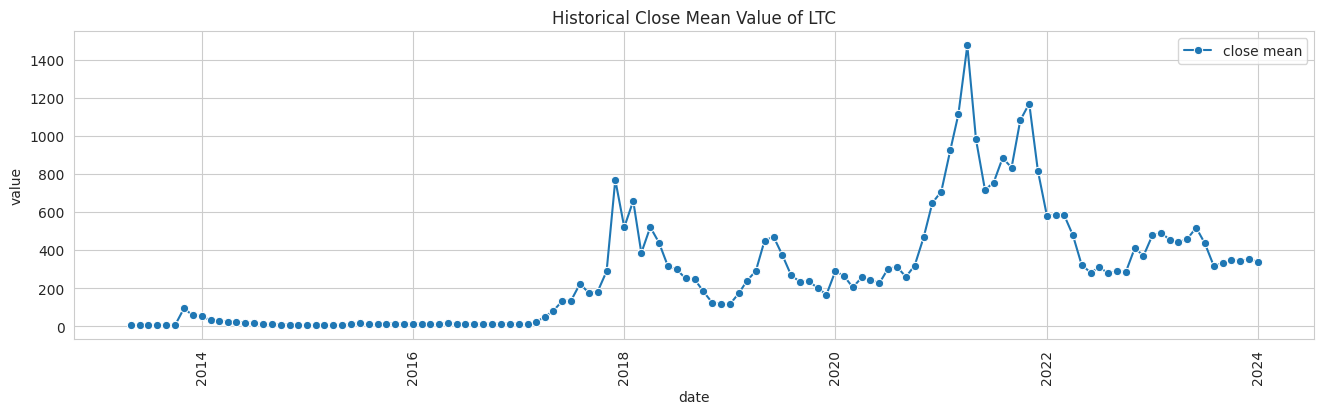

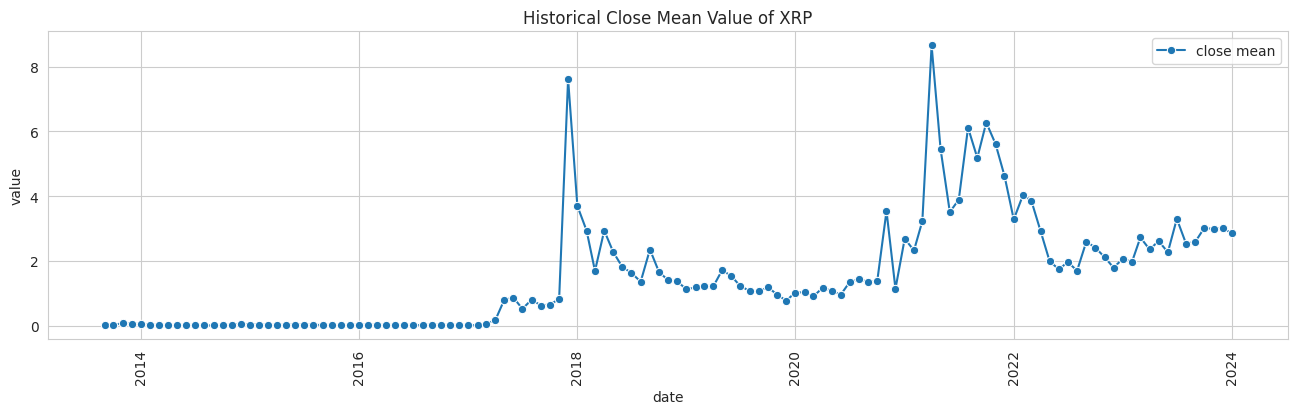

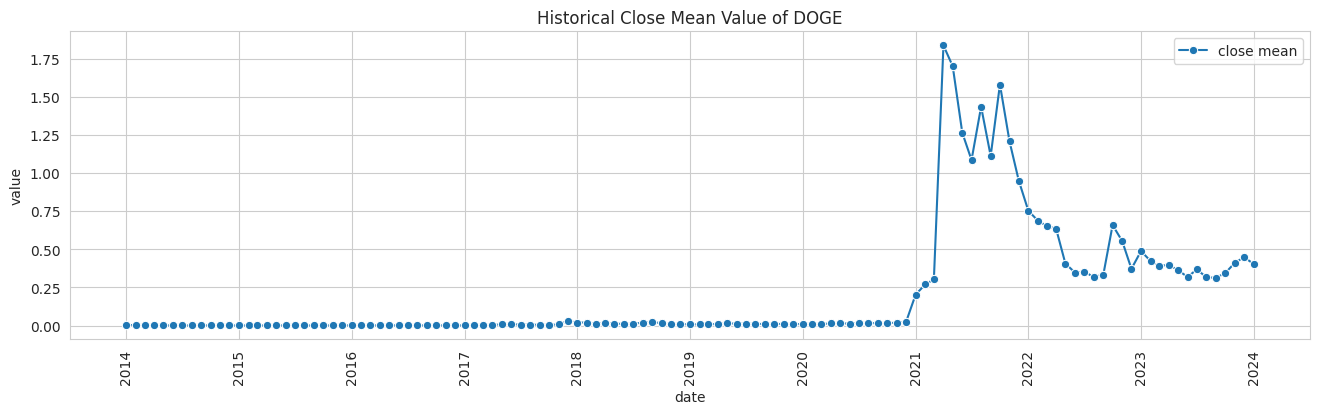

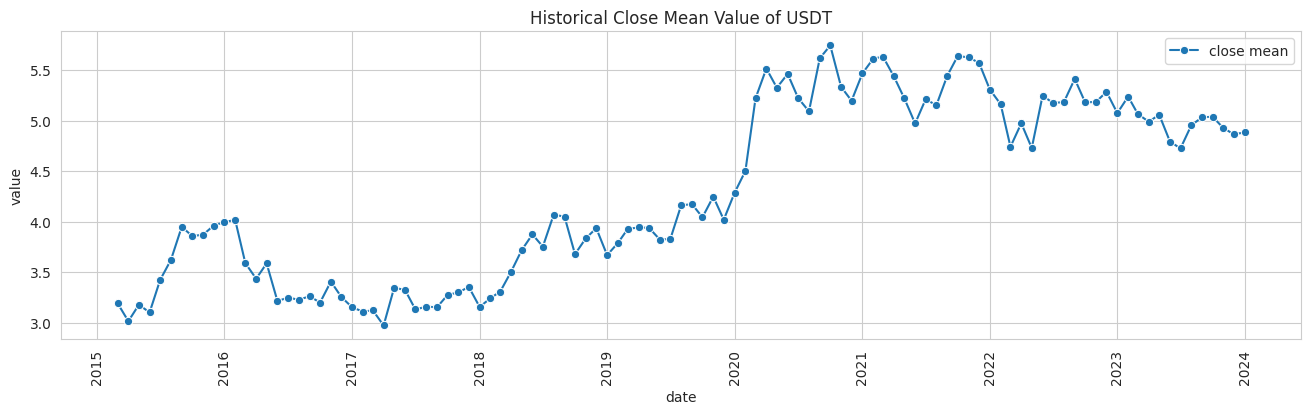

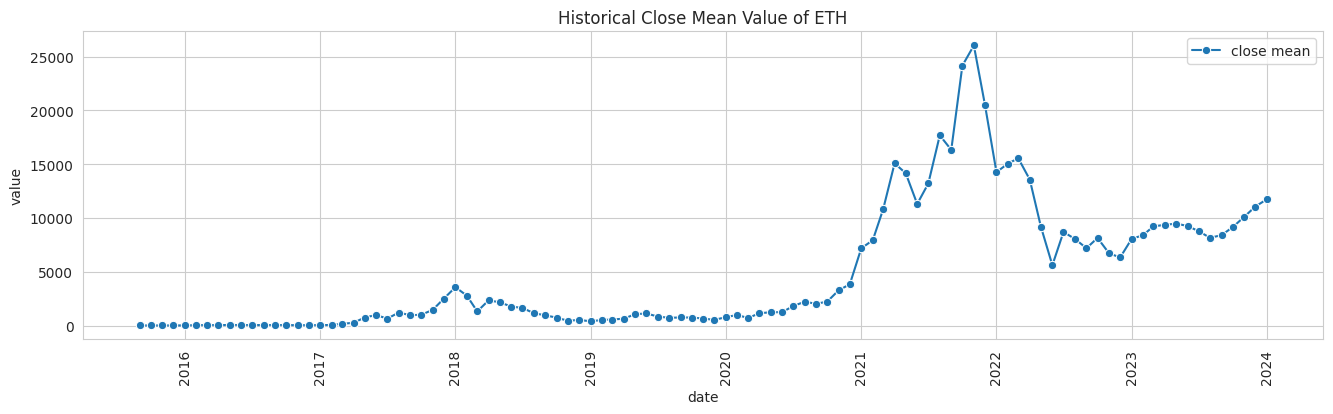

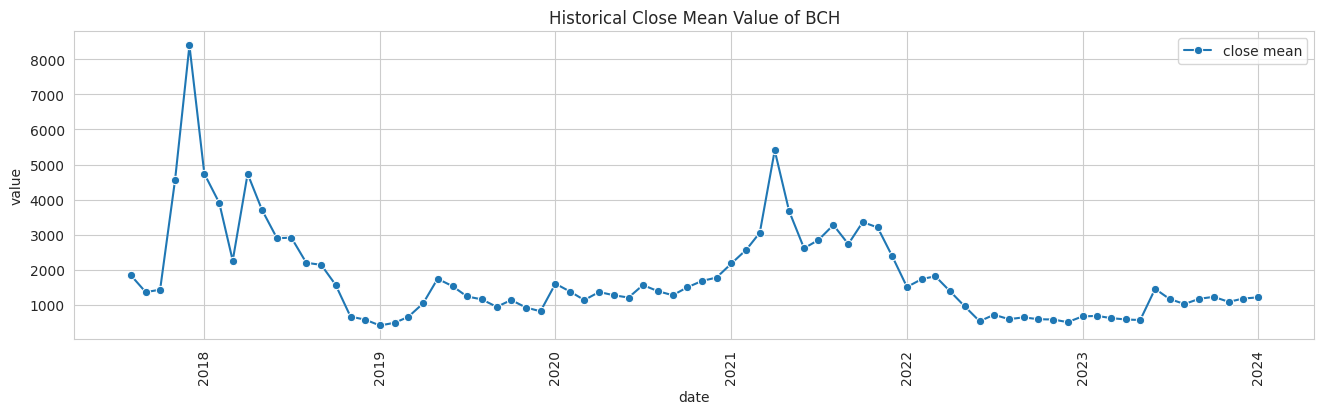

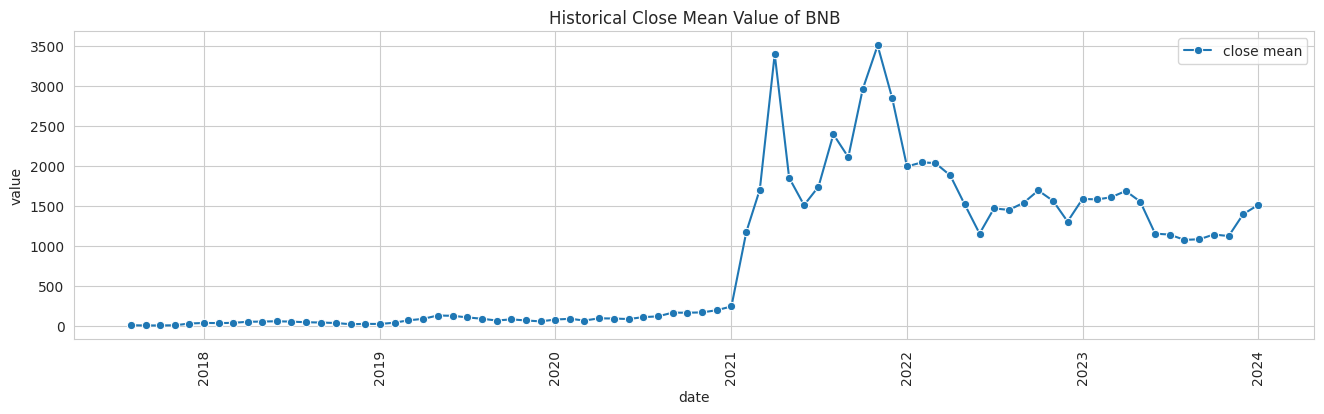

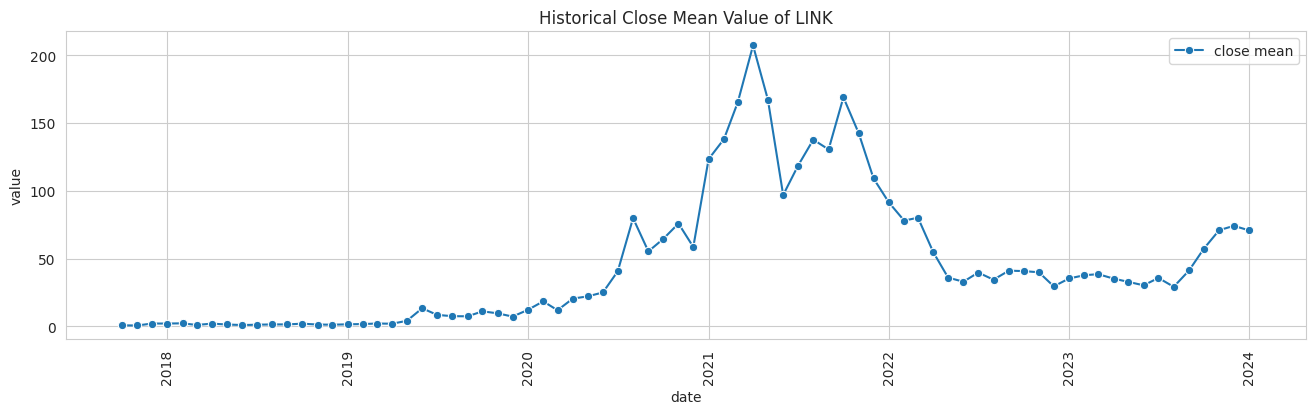

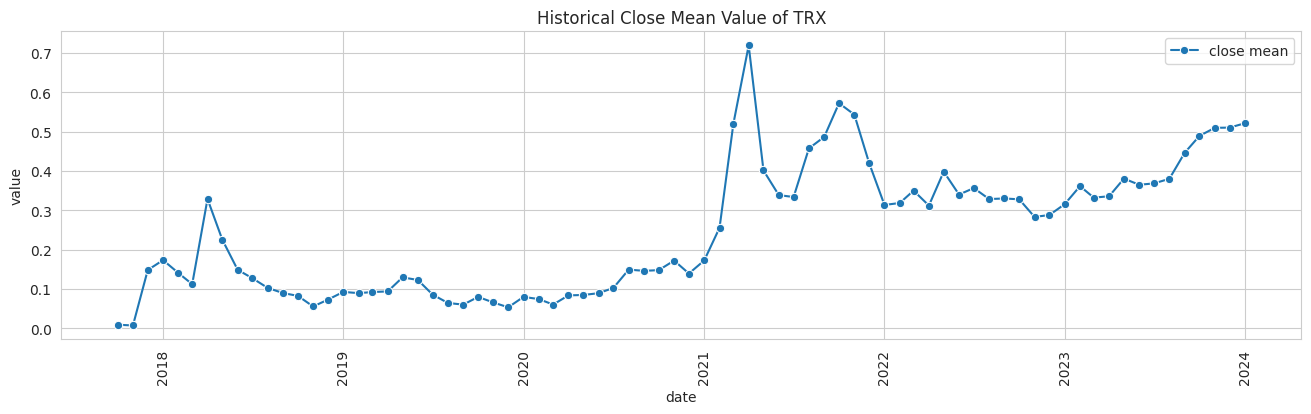

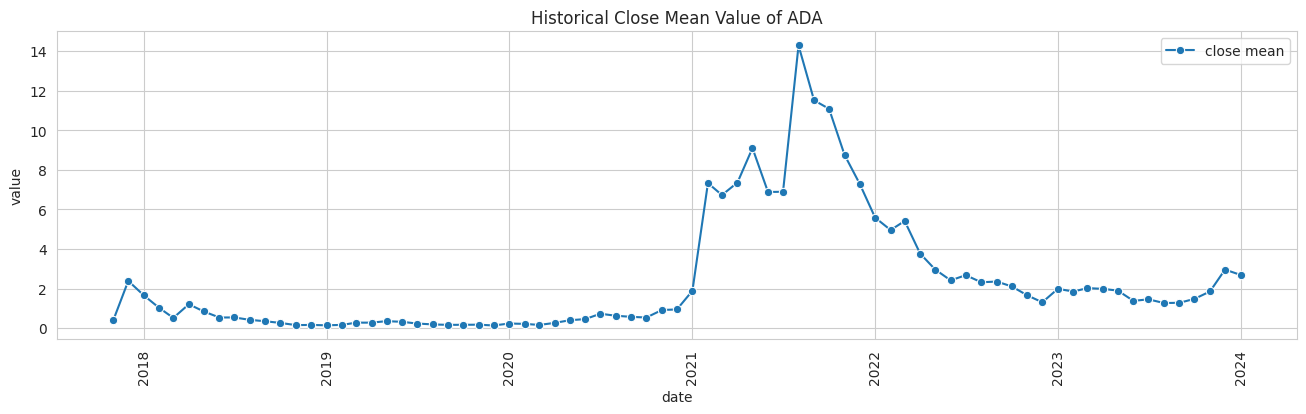

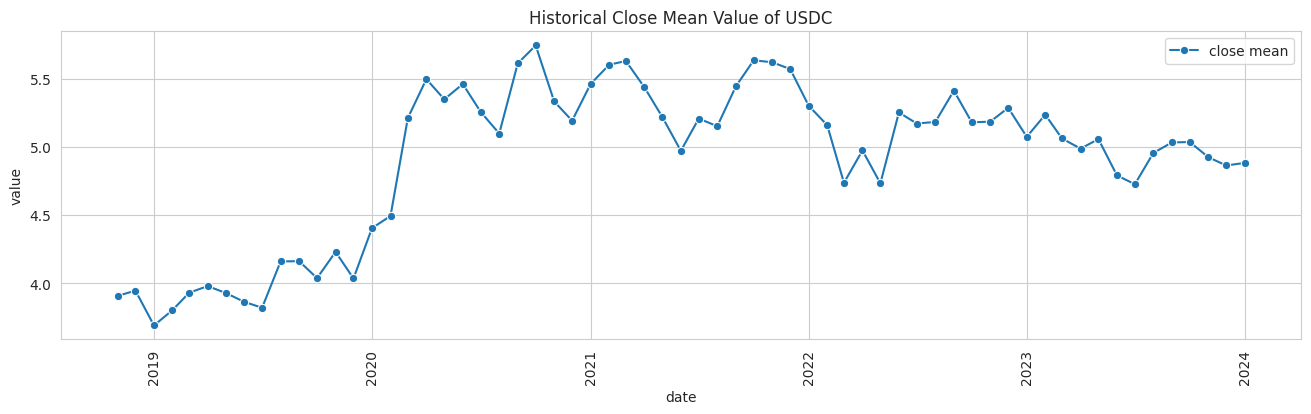

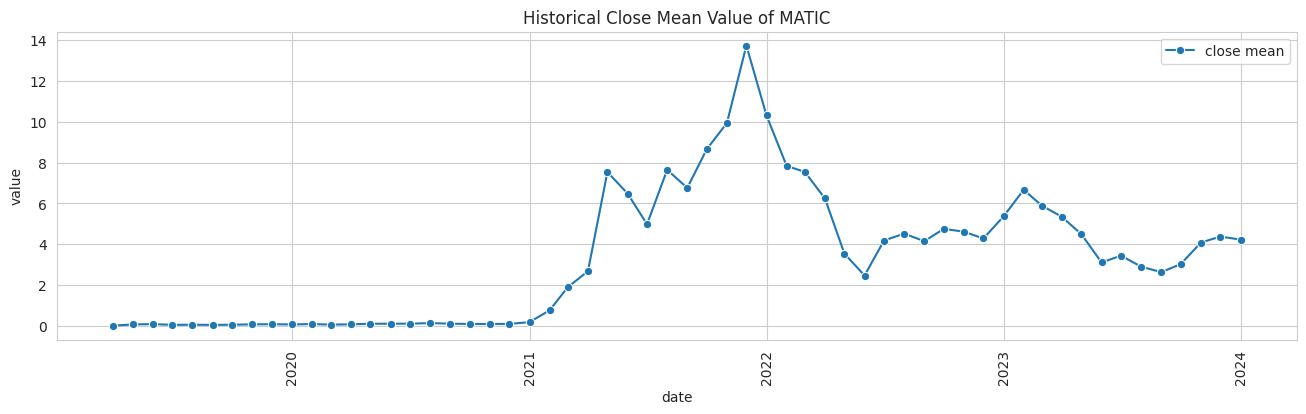

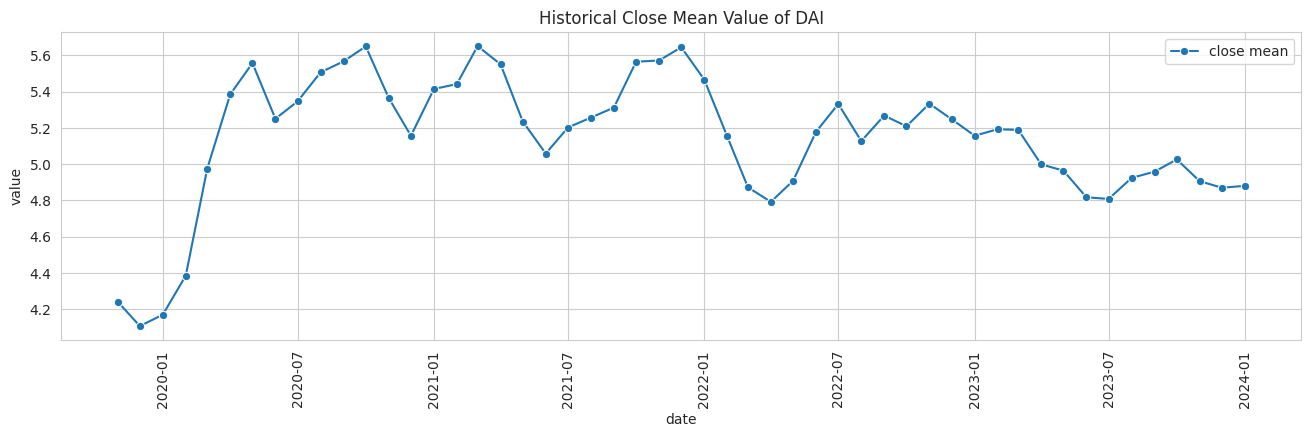

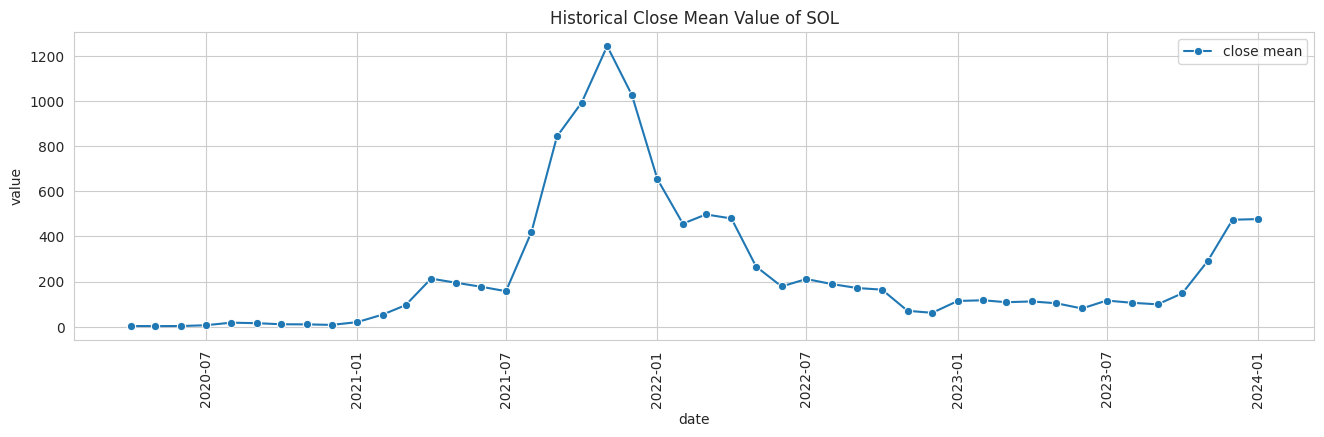

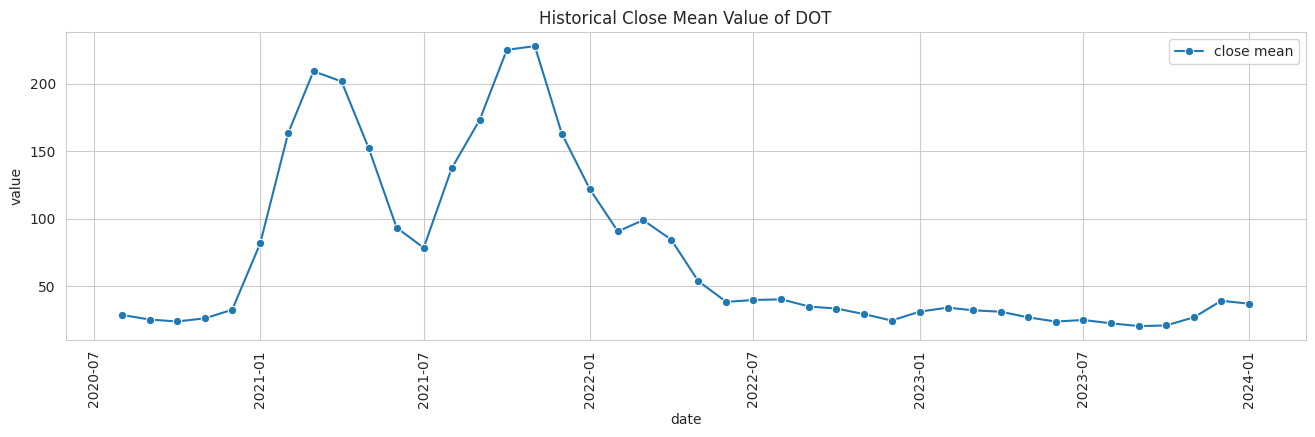

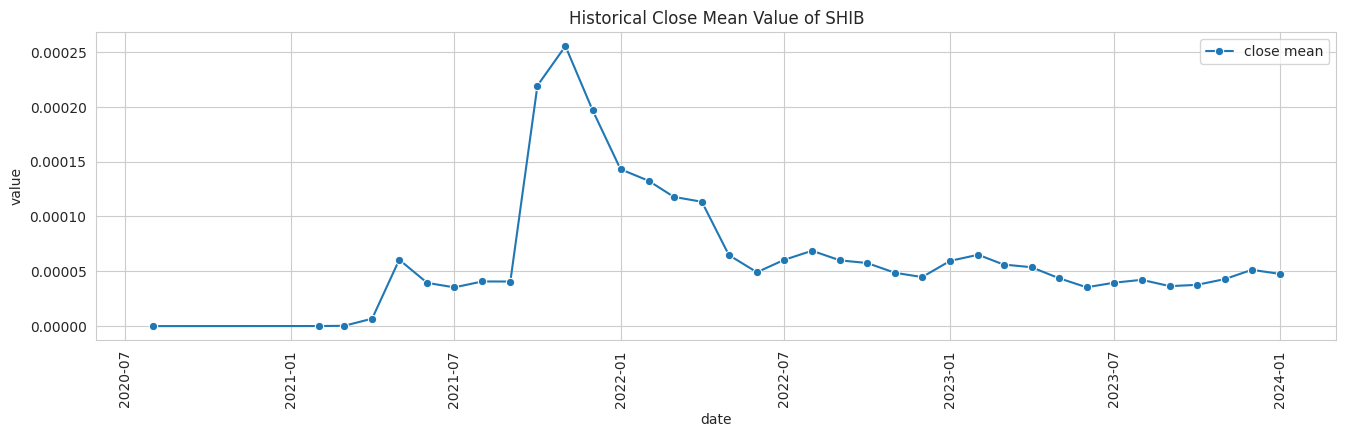

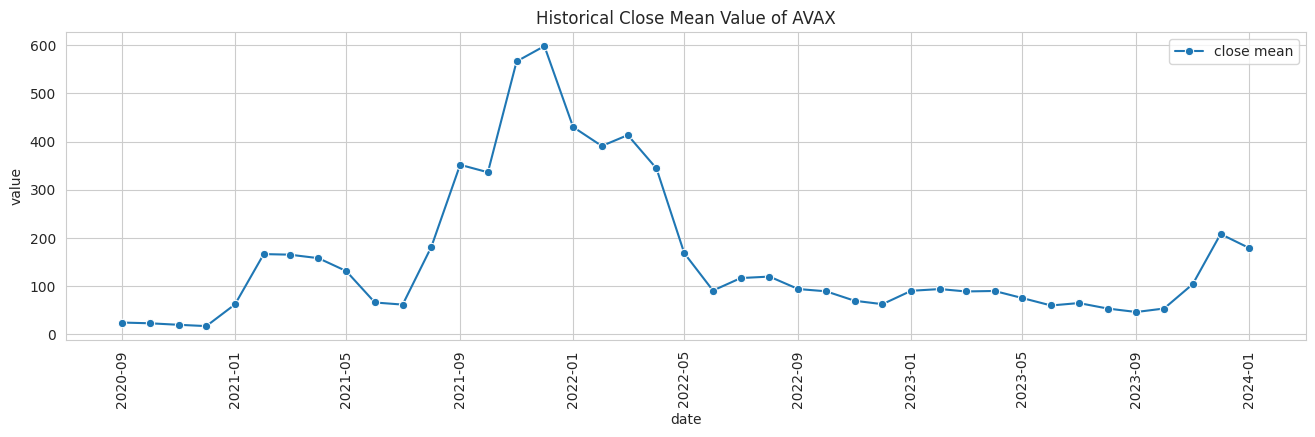

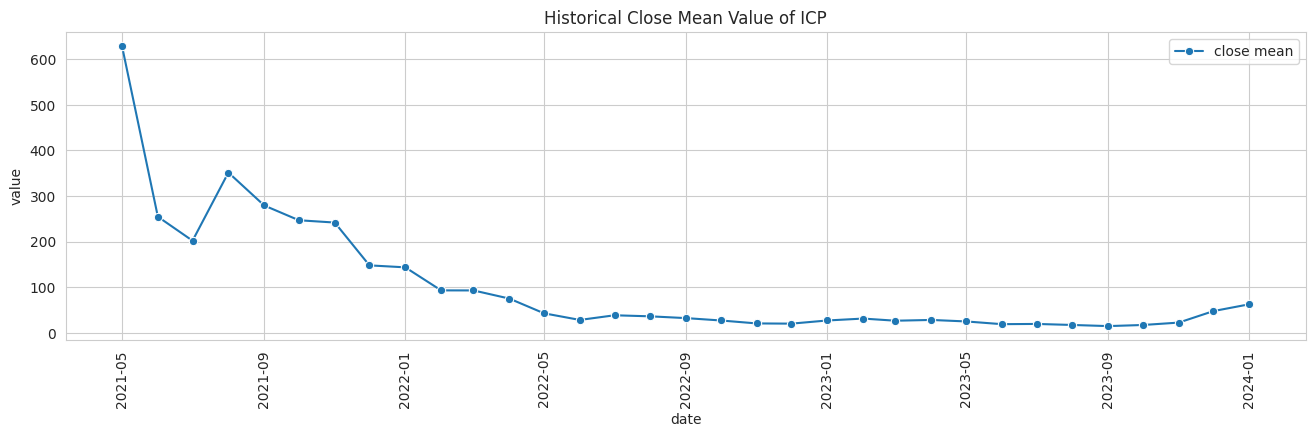

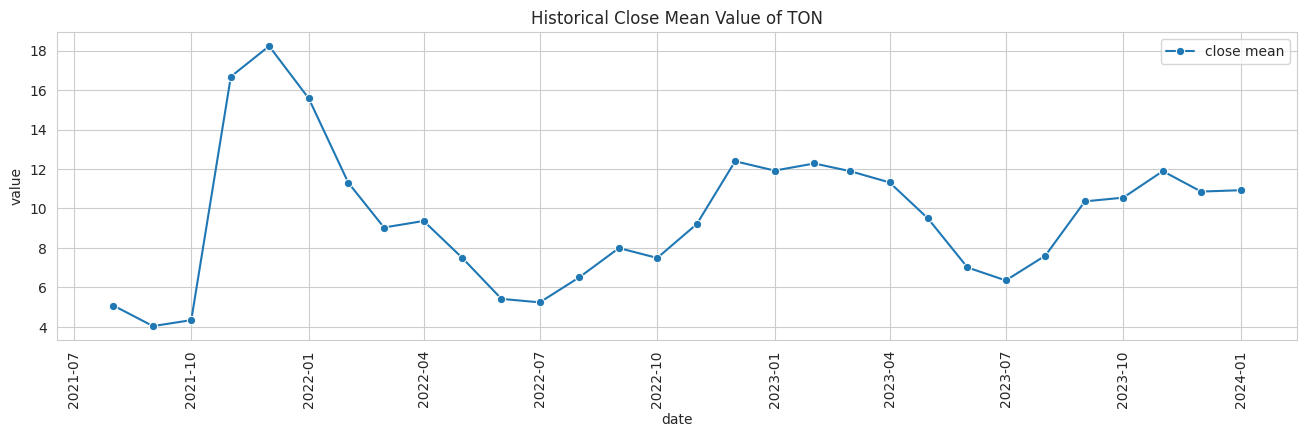

In [110]:
df_month_mean['close_mean_log'] = np.log(df_month_mean['close_mean'] + 1)  # Adicionando 1 para evitar log(0)

for tk in df_month_mean["ticker"].unique():
  db_temp = df_month_mean[df_month_mean["ticker"] == tk]

  # Plotando o histórico
  sns.lineplot(x='month', y='close_mean', data=db_temp, label='close mean', marker='o')

  # Configurando o título e os rótulos dos eixos
  plt.title(f'Historical Close Mean Value of {tk}')
  plt.xlabel('date')
  plt.ylabel('value')

  # Girando os rótulos dos meses em 90 graus
  plt.xticks(rotation=90)

  # Exibindo a legenda
  plt.legend()

  # Exibindo o gráfico
  plt.show()

In [111]:
# pivotando para colunas para usar as demais como features
df_month_mean_pivot = df_month_mean.pivot_table(index='month', columns='ticker', values='close_mean')
df_month_mean_pivot.columns = df_month_mean_pivot.columns.astype(str) # tornando todos os nomes string
df_month_mean_pivot = df_month_mean_pivot.fillna(0)
df_month_mean_pivot.columns.name = None # removendo o nome da tabela que apareceria como colune
df_month_mean_pivot = df_month_mean_pivot.reset_index()
df_month_mean_pivot

,month,ADA,AVAX,BCH,BNB,BTC,DAI,DOGE,DOT,ETH,ICP,LINK,LTC,MATIC,SHIB,SOL,TON,TRX,USDC,USDT,XRP
0,2013-04-01,0.000000,0.000000,0.000000,0.000000,278.528200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2013-05-01,0.000000,0.000000,0.000000,0.000000,276.292200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.332617,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2013-06-01,0.000000,0.000000,0.000000,0.000000,215.594137,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.651075,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2013-07-01,0.000000,0.000000,0.000000,0.000000,241.503268,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.530263,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2013-08-01,0.000000,0.000000,0.000000,0.000000,322.417250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.154942,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,2023-09-01,1.278491,46.015746,1179.371614,1081.088215,135716.038785,4.958072,0.312727,20.429899,8410.121815,15.201461,41.170842,332.495495,2.632787,0.000036,99.625336,10.357611,0.446303,5.033031,5.033556,2.593777
126,2023-10-01,1.476118,53.262540,1233.160901,1140.374171,174590.403638,5.025588,0.343852,20.903611,9147.868826,17.628649,57.285776,347.236878,3.028750,0.000038,148.516970,10.544974,0.489373,5.035799,5.037686,3.023081
127,2023-11-01,1.851059,103.991059,1091.157949,1121.206116,185712.655127,4.905604,0.410780,27.015103,10107.607140,22.868496,70.933182,341.977831,4.081885,0.000043,292.219539,11.889663,0.509749,4.924432,4.925170,2.985949
128,2023-12-01,2.956636,207.983406,1183.686354,1393.735938,208828.524615,4.869625,0.447636,39.187583,11061.517171,48.101172,74.160646,353.291442,4.374807,0.000051,474.193111,10.853732,0.510296,4.863749,4.864400,3.025213


In [112]:
# SAVE SILVER
#gold_path = glob.glob('../gold/')
gold_save_path = "../content/drive/MyDrive/01 - Projetos/crypto_forecast/gold/"
filename = "df_gold.parquet"
gold_save_path = gold_save_path + filename

df_month_mean_pivot.to_parquet(gold_save_path)

# ANALYSIS

- [ ] Previsão Univariada
- [ ] Previsão Multivariada
- [ ] Previsão com modelos de Bagging e Boosting

## Previsão Univariada

In [113]:
df = pd.read_parquet(gold_save_path)
df.set_index("month", inplace=True)
df.head()

,ADA,AVAX,BCH,BNB,BTC,DAI,DOGE,DOT,ETH,ICP,LINK,LTC,MATIC,SHIB,SOL,TON,TRX,USDC,USDT,XRP
month,,,,,,,,,,,,,,,,,,,,
2013-04-01,0.0,0.0,0.0,0.0,278.528200,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-05-01,0.0,0.0,0.0,0.0,276.292200,0.0,0.0,0.0,0.0,0.0,0.0,6.332617,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-06-01,0.0,0.0,0.0,0.0,215.594137,0.0,0.0,0.0,0.0,0.0,0.0,6.651075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-07-01,0.0,0.0,0.0,0.0,241.503268,0.0,0.0,0.0,0.0,0.0,0.0,6.530263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-08-01,0.0,0.0,0.0,0.0,322.417250,0.0,0.0,0.0,0.0,0.0,0.0,6.154942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2055.411, Time=1.50 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2061.167, Time=0.36 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2056.270, Time=0.75 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2054.439, Time=1.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2063.710, Time=0.78 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2055.394, Time=2.67 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2057.673, Time=3.46 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2054.110, Time=2.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2055.171, Time=1.36 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2055.496, Time=1.38 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2056.028, Time=0.72 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=1.52 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 17.952 seconds


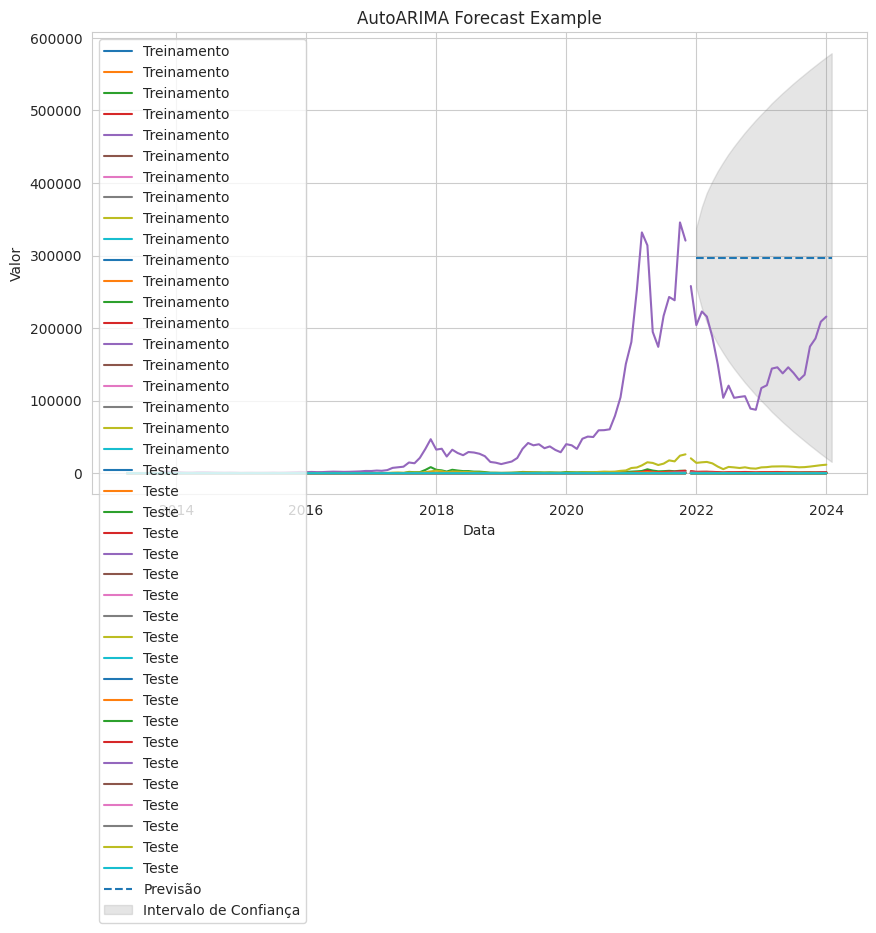

In [114]:
# Dividir os dados em treinamento e teste
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# Ajustar o modelo AutoARIMA aos dados de treinamento
model = auto_arima(train["BTC"].values, train.drop("BTC", axis=1).values,
                   seasonal=False, #m=12,
                   d=1, start_p=1, start_q=1, max_p=3, max_q=3,
                       #seasonal=True,
                       m=12, D=1, start_P=1, start_Q=1, max_P=2, max_Q=2, information_criterion='aic',
                       trace=True, error_action='ignore', stepwise=True
                   )  # m é o número de períodos em uma temporada (por exemplo, 7 para dados diários com uma semana de temporada)
model.fit(train["BTC"].values)

# Fazer previsões para o conjunto de teste
forecast, conf_int = model.predict(n_periods=len(test), return_conf_int=True)

# Criar um DataFrame para armazenar as previsões
forecast_index = pd.date_range(start=test.index[0], periods=len(test), freq='m')
forecast_df = pd.DataFrame(forecast, columns=['predicted'], index=forecast_index)

# Plotar os resultados
plt.figure(figsize=(10, 6))
plt.plot(train, label='Treinamento')
plt.plot(test, label='Teste')
plt.plot(forecast_df, label='Previsão', linestyle='dashed')
plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='gray', alpha=0.2, label='Intervalo de Confiança')
plt.legend()
plt.title('AutoARIMA Forecast Example')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.show()

In [116]:
target = "BTC"
thresh = 0.9

correlations = df.corrwith(df[target], method="pearson")
high_correlation_columns = correlations[(correlations.abs() > thresh)].index
high_correlation_columns = high_correlation_columns.to_list()
high_correlation_columns = [column for column in high_correlation_columns if column != target]
high_correlation_columns

['BNB', 'DOT', 'ETH', 'LINK', 'TRX']

In [117]:
df

,ADA,AVAX,BCH,BNB,BTC,DAI,DOGE,DOT,ETH,ICP,LINK,LTC,MATIC,SHIB,SOL,TON,TRX,USDC,USDT,XRP
month,,,,,,,,,,,,,,,,,,,,
2013-04-01,0.000000,0.000000,0.000000,0.000000,278.528200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2013-05-01,0.000000,0.000000,0.000000,0.000000,276.292200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.332617,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2013-06-01,0.000000,0.000000,0.000000,0.000000,215.594137,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.651075,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2013-07-01,0.000000,0.000000,0.000000,0.000000,241.503268,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.530263,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2013-08-01,0.000000,0.000000,0.000000,0.000000,322.417250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.154942,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-01,1.278491,46.015746,1179.371614,1081.088215,135716.038785,4.958072,0.312727,20.429899,8410.121815,15.201461,41.170842,332.495495,2.632787,0.000036,99.625336,10.357611,0.446303,5.033031,5.033556,2.593777
2023-10-01,1.476118,53.262540,1233.160901,1140.374171,174590.403638,5.025588,0.343852,20.903611,9147.868826,17.628649,57.285776,347.236878,3.028750,0.000038,148.516970,10.544974,0.489373,5.035799,5.037686,3.023081
2023-11-01,1.851059,103.991059,1091.157949,1121.206116,185712.655127,4.905604,0.410780,27.015103,10107.607140,22.868496,70.933182,341.977831,4.081885,0.000043,292.219539,11.889663,0.509749,4.924432,4.925170,2.985949


In [134]:
df_test = df.reset_index()
df_test

# Criando o objeto TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3, test_size=3)  # 5 * 3 = 15 predicoes in sample
random_state = 42

# Loop pelos splits do TimeSeriesSplit
for train_index, test_index in tscv.split(df_test):
    # Dividindo os dados em conjuntos de treinamento e teste
    train_data, test_data = df_test.iloc[train_index], df_test.iloc[test_index]

    # Separando as features e o alvo para treinamento e teste
    X_train, y_train = train_data[high_correlation_columns], train_data["BTC"]
    X_test, y_test = test_data[high_correlation_columns], test_data["BTC"]

    # Treinando e fazendo previsões com o modelo Random Forest
    random_forest_model.fit(X_train.values, y_train)
    rf_predictions = random_forest_model.predict(X_test).ravel()
    rf_column_name = f'{ticker}_RF'

    # Adicionando as previsões nos índices correspondentes
    df_test.loc[test_index, rf_column_name] = rf_predictions[:len(test_index)]

    # Treinando e fazendo previsões com o modelo XGBoost
    xgboost_model.fit(X_train.values, y_train)
    xgb_predictions = xgboost_model.predict(X_test).ravel()
    xgb_column_name = f'{ticker}_XGB'

    # Adicionando as previsões nos índices correspondentes
    df_test.loc[test_index, xgb_column_name] = xgb_predictions[:len(test_index)]

In [140]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

# Função para calcular o MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Criando o objeto TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5, test_size=3)  # 3 * 3 = 9 predições in sample (3 splits de 3 previsões cada)

# Inicializando variáveis para acumular resultados
mape_rf_total = 0
mape_xgb_total = 0

# Loop pelos splits do TimeSeriesSplit
for train_index, test_index in tscv.split(df_test):
    # Dividindo os dados em conjuntos de treinamento e teste
    train_data, test_data = df_test.iloc[train_index], df_test.iloc[test_index]

    # Separando as features e o alvo para treinamento e teste
    X_train, y_train = train_data[high_correlation_columns], train_data["BTC"]
    X_test, y_test = test_data[high_correlation_columns], test_data["BTC"]

    # Treinando e fazendo previsões com o modelo Random Forest
    random_forest_model.fit(X_train.values, y_train)
    rf_predictions = random_forest_model.predict(X_test).ravel()

    # Calculando o MAPE para Random Forest
    mape_rf = calculate_mape(y_test, rf_predictions)
    mape_rf_total += mape_rf

    # Treinando e fazendo previsões com o modelo XGBoost
    xgboost_model.fit(X_train.values, y_train)
    xgb_predictions = xgboost_model.predict(X_test).ravel()

    # Calculando o MAPE para XGBoost
    mape_xgb = calculate_mape(y_test, xgb_predictions)
    mape_xgb_total += mape_xgb

# Calculando a média dos MAPEs
mape_rf_mean = mape_rf_total / tscv.n_splits
mape_xgb_mean = mape_xgb_total / tscv.n_splits

print(f'MAPE médio para Random Forest: {mape_rf_mean:.2f}%')
print(f'MAPE médio para XGBoost: {mape_xgb_mean:.2f}%')

MAPE médio para Random Forest: 16.52%
MAPE médio para XGBoost: 21.56%


In [141]:
df_test[["month", "BTC", "BTC_RF", "BTC_XGB"]].tail(10)

,month,BTC,BTC_RF,BTC_XGB
120,2023-04-01,145978.175128,NaN,NaN
121,2023-05-01,137630.759820,112224.477043,91432.671875
122,2023-06-01,145979.938192,104141.637431,91750.781250
123,2023-07-01,138144.427024,99907.192348,90588.906250
124,2023-08-01,128500.820776,107498.551371,89096.812500
125,2023-09-01,135716.038785,119519.512162,102050.296875
126,2023-10-01,174590.403638,155628.490765,151510.421875
127,2023-11-01,185712.655127,168061.392092,171954.234375
128,2023-12-01,208828.524615,172703.397089,152781.265625
129,2024-01-01,215901.032926,173694.521105,152781.265625


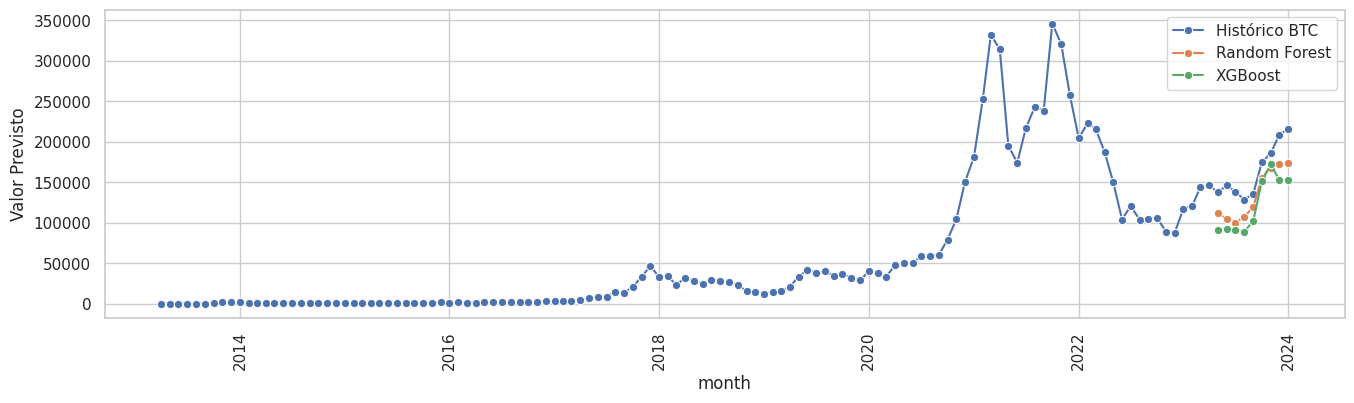

In [143]:
import seaborn as sns

df_test_copy = df_test #.tail(20).copy()

# Configurando o estilo do seaborn
sns.set(style="whitegrid")

# Loop pelos componentes
# for component, features in external_variables_dict.items():
sns.lineplot(x=df_test_copy["month"], y=df_test_copy["BTC"].values, marker='o', label=f'Histórico BTC', data=df_test_copy) #, ax=ax)
sns.lineplot(x=df_test_copy["month"], y=df_test_copy[f'BTC_RF'].values, marker='o', label=f'Random Forest', data=df_test_copy) #, ax=ax)
sns.lineplot(x=df_test_copy["month"], y=df_test_copy[f'BTC_XGB'].values, marker='o', label=f'XGBoost', data=df_test_copy) #, ax=ax)

# Configurações adicionais do gráfico
#plt.title(f'Previsões para o componente {component}')
#plt.xlabel('Índice Temporal')
plt.ylabel('Valor Previsto')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [ ]:
STOP

In [ ]:
# Threshold para correlação
thresh = 0.8

# Dicionário para armazenar as variáveis externas com alta correlação
external_variables_dict = {}

# Iterar sobre as colunas do DataFrame
for column in df.columns:
    # Verificar se a coluna não é o alvo
    if column != target:
        # Calcular as correlações
        correlations = df.corrwith(df[column], method="pearson")
        high_correlation_columns = correlations[(correlations.abs() > thresh)].index.to_list()

        # Remover a coluna de alvo da lista, se presente
        high_correlation_columns = [col for col in high_correlation_columns if col != column]

        # Armazenar no dicionário
        external_variables_dict[column] = high_correlation_columns

# Exibir o dicionário resultante
#external_variables_dict

In [ ]:
# Carregando o conjunto de dados
#df = pd.read_parquet(gold_save_path)
data_forecast = df.copy()

# Criando o objeto TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5, test_size=3)  # 5 * 3 = 15 predicoes in sample
random_state = 42

# Inicializando os modelos
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=random_state)
xgboost_model = XGBRegressor(objective='reg:squarederror', random_state=random_state)

# Dicionário de modelos para facilitar o loop
models = {'RF': random_forest_model, 'XGB': xgboost_model}

# Inicializando o DataFrame para armazenar as métricas
df_metrics = pd.DataFrame()

# Loop pelos componentes
for ticker, features in external_variables_dict.items():
    features = list(features)
    print(f"Treinando {ticker}")

    # Loop pelos splits do TimeSeriesSplit
    for train_index, test_index in tscv.split(data_forecast):
        # Dividindo os dados em conjuntos de treinamento e teste
        train_data, test_data = data_forecast.iloc[train_index], data_forecast.iloc[test_index]

        # Separando as features e o alvo para treinamento e teste
        X_train, y_train = train_data[features], train_data[ticker]
        X_test, y_test = test_data[features], test_data[ticker]

        # Treinando e fazendo previsões com o modelo Random Forest
        random_forest_model.fit(X_train.values, y_train)
        rf_predictions = random_forest_model.predict(X_test).ravel()
        rf_column_name = f'{ticker}_RF'

        # Adicionando as previsões nos índices correspondentes
        data_forecast.loc[test_index, rf_column_name] = rf_predictions[:len(test_index)]

        # Treinando e fazendo previsões com o modelo XGBoost
        xgboost_model.fit(X_train.values, y_train)
        xgb_predictions = xgboost_model.predict(X_test).ravel()
        xgb_column_name = f'{ticker}_XGB'

        # Adicionando as previsões nos índices correspondentes
        data_forecast.loc[test_index, xgb_column_name] = xgb_predictions[:len(test_index)]

In [ ]:
stop

In [ ]:
# from datetime import datetime
# import time

# # Criar um objeto datetime para a data "01/01/2020"
# data = datetime.strptime("01/01/2020", "%m/%d/%Y")

# # Obter o timestamp UNIX
# timestamp_unix = int(time.mktime(data.timetuple()))

# print(f"A data '2023/01/17' em UNIX timestamp é: {timestamp_unix}")

# import pandas as pd
# import requests

# # url = "https://api.coinmarketcap.com/data-api/v3.1/cryptocurrency/historical?id=8916&timeStart=1673982000&interval=1d&convertId=2783"
# url = f"https://api.coinmarketcap.com/data-api/v3.1/cryptocurrency/historical?id=4943&timeStart=1577836800&interval=1d&convertId=2783"

# # Fazendo a requisição GET
# response = requests.get(url)

# # Verificando se a requisição foi bem-sucedida (código de status 200)
# if response.status_code == 200:
#     # O conteúdo da resposta em formato JSON
#     data = response.json()

#     # Normalizando o JSON e criando um DataFrame
#     df = pd.json_normalize(data['data']['quotes'])

# else:
#     # Se a requisição falhar, exibimos o código de status
#     print(f"Falha na requisição. Código de status: {response.status_code}")

# df

In [ ]:
stop

In [ ]:
# # Criando um DataFrame consolidado com a coluna 'date'
# # consolidated_df = pd.DataFrame(columns=['date'])
# consolidated_df = pd.DataFrame()

# # Adicionando as informações de cada DataFrame a 'consolidated_df'
# for name, df in data_frames.items():
#     # Renomeando as colunas para evitar conflitos
#     renamed_columns = {col: f"{col}_{name}" for col in df.columns if col != 'date'}
#     df_renamed = df.rename(columns=renamed_columns)

#     # Mesclando os DataFrames pelo valor da coluna 'date'
#     #consolidated_df = pd.merge(consolidated_df, df_renamed, on='date', how='outer')
#     consolidated_df = pd.concat([consolidated_df, df_renamed], ignore_index=True, sort=False)

# # Ordenando as colunas pelo nome da moeda
# #consolidated_df = consolidated_df.reindex(sorted(consolidated_df.columns), axis=1)

# # Exibindo o DataFrame consolidado
# consolidated_df.sort_values(by='date')

In [ ]:
# # Criando um DataFrame consolidado com a coluna 'date' como índice
# consolidated_df = pd.DataFrame()

# # Adicionando as informações de cada DataFrame a 'consolidated_df'
# for name, df in data_frames.items():
#     # Renomeando as colunas para evitar conflitos
#     renamed_columns = {col: f"{col}_{name}" for col in df.columns}
#     df_renamed = df.rename(columns=renamed_columns)

#     # Concatenando DataFrames
#     consolidated_df = consolidated_df.merge(df_renamed, on='date')
#     #consolidated_df = pd.concat([consolidated_df, df_renamed], axis=1)

#     # Configurando 'date' como índice
#     #df_renamed.set_index('date', inplace=True)

# # Exibindo o DataFrame consolidado
# consolidated_df

In [ ]:
# load external variables
btc = pd.read_csv('../external_variables/btc.csv', sep=';')
eth = pd.read_csv('../external_variables/eth.csv', sep=';')

# rename
cols_to_keep = ['close', 'volume', 'marketCap', 'timestamp']
cols_to_rename = {'timestamp': 'date', 'marketCap': 'market_cap'}

btc = btc[cols_to_keep].rename(columns=cols_to_rename)
eth = eth[cols_to_keep].rename(columns=cols_to_rename)

# format date
btc['date'] = pd.to_datetime(btc['date'], yearfirst=True, format="%Y-%m-%d") #.dt("%Y-%m-%d")
eth['date'] = pd.to_datetime(eth['date']) #.strptime("%Y-%m-%d")

# time tag
btc['status'] = 'past'

In [ ]:
# checking seasonality
from statsmodels.tsa.seasonal import seasonal_decompose

df_test = btc[['close', 'date']].set_index('date').copy()

resultado = seasonal_decompose(df_test) #, freq='d')

fig = plt.figure(figsize=(25, 10))
fig = resultado.plot()

In [ ]:
# checking seasonality
from statsmodels.tsa.seasonal import seasonal_decompose

df_test = btc[['close', 'date']].set_index('date').copy()

resultado = seasonal_decompose(df_test, model='multiplicative') #, freq='d')

fig = plt.figure(figsize=(25, 10))
fig = resultado.plot()

In [ ]:
# Teste de estacionariedade
# A hipótese nula é que a série não é estacionária
# p-value < 0,05 = estacionária
# p-value > 0,05 = não estacionária

from statsmodels.tsa.stattools import adfuller

result = adfuller(df_test)

print(f'Teste ADF:{result[0]}')
print(f'p-valor:{result[1]}')

In [ ]:
import pandas as pd



# Estima o modelo ARIMA com temperatura como variável exógena
# model = pm.auto_arima(btc['close'], exog=btc[['volume', 'market_cap']])

start_ = len(btc)
end_ = len(btc) + 15
n_periods_ = end_ - start_ +1

# Prevê as próximas observações
# predictions = model.predict(start=start_, end=end_,
#                             n_periods=n_periods_,
# #                             out_of_sample_size=4,
# #                             scoring = 'mean_absolute_percentage_error'
#                            )

y = btc['close']
x = btc[['volume', 'market_cap']]
predictions = pm.auto_arima(btc['close'],
                            #ndog=y,
                            #xog=x,
                            d=1,
                            start_p=1,
                            start_q=1,
                            max_p=3,
                            max_q=3,
                            seasonal=True,
                            m=6, D=1, start_P=1,
                            start_Q=1,
                            max_P=2,
                            max_Q=2,
                            information_criterion='aic',
                            trace=True,
                            error_action='ignore',
                            stepwise=True)


# # Cria um date range da última data do DataFrame `btc` até `n_periods` preditos
date_range = pd.date_range(btc['date'].max(), periods=n_periods_, freq='D')

# Cria um DataFrame `btc_preds`
btc_preds = pd.DataFrame({'date': date_range, 'close': predictions, 'status': 'forecast'})

# # diferencia valor historico e previsa

# #btc_preds['status'] = 'forecast'

# # cria dataframe com previsao
# btc_past = pd.DataFrame({'date': btc.index, 'close': btc['close'], 'status': 'past'})
btc_forecast = pd.concat([btc, btc_preds], ignore_index=True)

# btc

In [ ]:
ver https://github.com/k3ybladewielder/beer/blob/main/beer.ipynb

    https://colab.research.google.com/drive/1VdjA51o1fiGFxHb0Mj9YVpX-1NkKDeW8?authuser=4#scrollTo=35wBezyaR-cE

In [ ]:
model.get_params()

In [ ]:
btc_forecast

In [ ]:
btc_forecast

In [ ]:
sns.set_style("whitegrid")
plt.yticks(np.arange(0, int(btc["close"].max()), 1000))
sns.lineplot(x=btc_forecast['date'], y=btc_forecast['close'], hue=btc_forecast['status'], data=btc_forecast)

In [ ]:
from fbprophet import Prophet
m = Prophet()
m.fit(btc_df)

future = m.make_future_dataframe(periods=30)
future.tail()

# feature engineering